### NXCALS and pyspark


G. Sterbini with the help and support of the NXCALS team

### Introduction

- We will present few examples on how to use **pyspark** methods to access NXCALS. 

- [pyspark](https://spark.apache.org/docs/latest/api/python/index.html) is a **ready-to-use package** supported by the Apache/SPARK community.

- pyspark opens the possibility to make big data analysis and could be **complementary to pytimber**. 

Our aim here is to collect examples specific of our community and share them to optimize (and merge in future?) the different approaches.

We are using the SWAN/NXCALS environment but we also tested the pyspark bundle and pure python approach (refer to [NXCALS web page](http://nxcals-docs.web.cern.ch/current/user-guide/data-access/access-methods/)).


**We are NOT SPARK experts** but these examples (of incremental complexity) may bootstrap the discussion and help to build your own use-case.

For our purpose, we privileged the clarity/compactness of code to the completeness of the physics case.

### The logic
Given a time window (two ordered timestamps) and a list of variables, one can follow 4 logic steps/sets of dataframes (**df**):
1. Prepare a set of **single spark df's** (one per variable).
2. **Join** this set in a **common spark df**.
3. **Perform transformation** on the common spark df.
4. **Retrieve a reduced spark df** converting it to **pandas df**.

The emphasis is to do all transformation **before** step 4, hence make use of the NXCALS cluster.

To keep in mind:

- Working with the injectors data is in general easier (acquisition  done by cyclestamp: **synchronous** acquisition due to strongly-coupled/fixed-duration-cycles/PPM-telegram).

- Later we will show the more general case, e.g., LHC: **asynchronous** acquisition (weakly-coupled/no-fixed-duration-cycles/no-telegram)

### An auxiliary package

We put on https://github.com/sterbini/nx2pd (98 sloc) some recurrent functions we are going to use.

In [12]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})
from nx2pd import nx2pd as nx #install from https://github.com/sterbini/nx2pd
nx.spark=spark
pd=nx.pd
np=nx.np

### Example 1a (no transformation)

**Q: When and for which cycle a specific PS wire scanner was used?**

In this example we are not making transformation (so we are not using the cluster in a smart way).

In [3]:
t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
list_of_variables=['CPS.LSA:CYCLE','PR.BWS.65.H_ROT:SCAN_NUMBER']
# Step 1: set of single spark df's
pd_df_of_spark_df=nx.importNXCALS(list_of_variables, t1,t2)
# Step 2: inner-joining the pd_df on 'timestamp'
spark_df=nx._join_df_list(pd_df_of_spark_df, on=['timestamp'], how='inner')
# Step 3: going back to pandas df
# Nothing :(
# Step 4: going back to pandas df
pd_df=nx._to_pandas(spark_df, timestampConversion=True, sorted=True)
print(pd_df.head());print(f'A total of {len(pd_df)} records retrieved.')

                                 CPS.LSA:CYCLE  PR.BWS.65.H_ROT:SCAN_NUMBER
2018-03-05 14:43:51.900000+00:00    EAST_IRRAD                        46766
2018-03-05 14:44:35.100000+00:00    EAST_IRRAD                        46767
2018-03-07 08:41:18.300000+00:00    EAST_IRRAD                        46768
2018-03-07 08:41:48.300000+00:00    EAST_IRRAD                        46769
2018-03-10 09:50:08.700000+00:00   MTE_50_CORE                        46770
A total of 15829 records retrieved.


### Example 1b (with aggregation)

**Q: Same question, when and for which cycle a specific PS wire scanner was used?**

(now using aggregation)

In [4]:
t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
list_of_variables=['CPS.LSA:CYCLE','PR.BWS.65.H_ROT:SCAN_NUMBER']
# Step 1: set of single spark df's
pd_df_of_spark_df=nx.importNXCALS(list_of_variables, t1,t2)
# Step 2: inner-joining the pd_df on 'timestamp'
spark_df=nx._join_df_list(pd_df_of_spark_df, on=['timestamp'], how='inner')
# Step 3: aggregating the data
spark_df=spark_df.groupby('CPS@LSA:CYCLE').agg(nx.func.count("PR@BWS@65@H_ROT:SCAN_NUMBER").alias('count'))
# Step 4: going back to pandas df
pd_df=nx._to_pandas(spark_df,sorted=False).sort_values('count',ascending=False).set_index('CPS.LSA:CYCLE');pd_df.index.name=None;
print(pd_df.head(5));print(f'A total of {len(pd_df)} records retrieved.')

                                   count
MD4263_LHC25#48B_BCMS_PS_TFB_2018   2101
MD4404_BCMS                         1967
MD2586_LHC25#12B_BCMS_PS            1684
LHC25#48B_BCMS_PS                   1064
MD4407_LHC25#12B_BCMS                849
A total of 108 records retrieved.


### Example 2a (3 years aggregation)
**Q: What is the statistics of the production cycles (first injection current) in the PS during Run2?**

You can do that in less than 1 minutes in 2020/05/29 SWAN standard configuration!

In [7]:
t1=pd.Timestamp('2016', tz='UTC'); t2=pd.Timestamp('2019', tz='UTC')
pd_df=nx.importNXCALS(['CPS.TGM:USER','PR.DCAFTINJ_1:INTENSITY'], t1,t2)
df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
df=df.dropna()\
    .groupby('CPS@TGM:USER').agg(nx.func.count("PR@DCAFTINJ_1:INTENSITY").alias('count'),\
                                    nx.func.sum("PR@DCAFTINJ_1:INTENSITY"),\
                                    nx.func.mean("PR@DCAFTINJ_1:INTENSITY"))
aux=nx._to_pandas(df)
aux=aux.sort_values('CPS.TGM:USER').set_index('CPS.TGM:USER').sort_values('sum(PR.DCAFTINJ_1:INTENSITY)', ascending=False)
aux.index.name=None;print(aux.head());print(f'Total number of cycles: {aux["count"].sum()}')

           count  sum(PR.DCAFTINJ_1:INTENSITY)  avg(PR.DCAFTINJ_1:INTENSITY)
TOF      7785564                  5.312979e+09                    682.414171
SFTPRO1  2972325                  3.270464e+09                   1100.304861
SFTPRO2  2242740                  1.862863e+09                    830.619392
EAST1    3814038                  1.044577e+09                    273.876976
EAST2    3677046                  1.008520e+09                    274.274491
Total number of cycles: 54628119


### Example 2b (1 minute aggregation)
**CAVEAT:** clearly it is faster but, as expected, there are overheads.

In [10]:
t1=pd.Timestamp('2018-10-01', tz='UTC'); t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
pd_df=nx.importNXCALS(['CPS.TGM:USER','PR.DCAFTINJ_1:INTENSITY'], t1,t2)
df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
df=df.dropna()\
    .groupby('CPS@TGM:USER').agg(nx.func.count("PR@DCAFTINJ_1:INTENSITY").alias('count'),\
                                    nx.func.sum("PR@DCAFTINJ_1:INTENSITY").alias('sum'),\
                                    nx.func.mean("PR@DCAFTINJ_1:INTENSITY").alias('mean'),\
                                    nx.func.stddev("PR@DCAFTINJ_1:INTENSITY").alias('std'))
aux=nx._to_pandas(df)
aux=aux.sort_values('CPS.TGM:USER').set_index('CPS.TGM:USER').sort_values('sum', ascending=False)
aux.index.name=None;print(aux.head());print(f'Total number of cycles: {aux["count"].sum()}')

         count           sum         mean         std
SFTPRO1      8  11461.413086  1432.676636   18.081495
TOF          8   6481.819397   810.227425    9.617653
EAST1        7   2806.542114   400.934588    2.437349
EAST2        4    880.980518   220.245130  208.533554
MD6          2    156.822815    78.411407    5.531555
Total number of cycles: 35


### Example 3 (daily cumulative aggregation)

**Q: plot the integrated daily extracted current on PS TOF cycle for the 2018**

We make explicit operation on the column 'timestamp' before aggregation and we use filtering.

In [11]:
t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
pd_df=nx.importNXCALS(['CPS.TGM:USER','PR.DCBEFEJE_1:INTENSITY'], t1,t2)
df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
df=df.filter(nx.col('CPS@TGM:USER')=='TOF')
df=df.withColumn('new_timestamp',nx.col('timestamp')/1.0e9)
df = df.withColumn('new_timestamp',nx.func.from_unixtime("new_timestamp", "yyyy-MM-dd HH:mm:ss"))
df_agg = df.groupBy(nx.func.to_date('new_timestamp').alias('Day')).agg(nx.func.sum('PR@DCBEFEJE_1:INTENSITY').alias('value'))
# to pandas
aux=nx._to_pandas(df_agg)
# minimal operation in pandas after aggregation
aux=aux.sort_values('Day').set_index('Day');aux.index.name=None

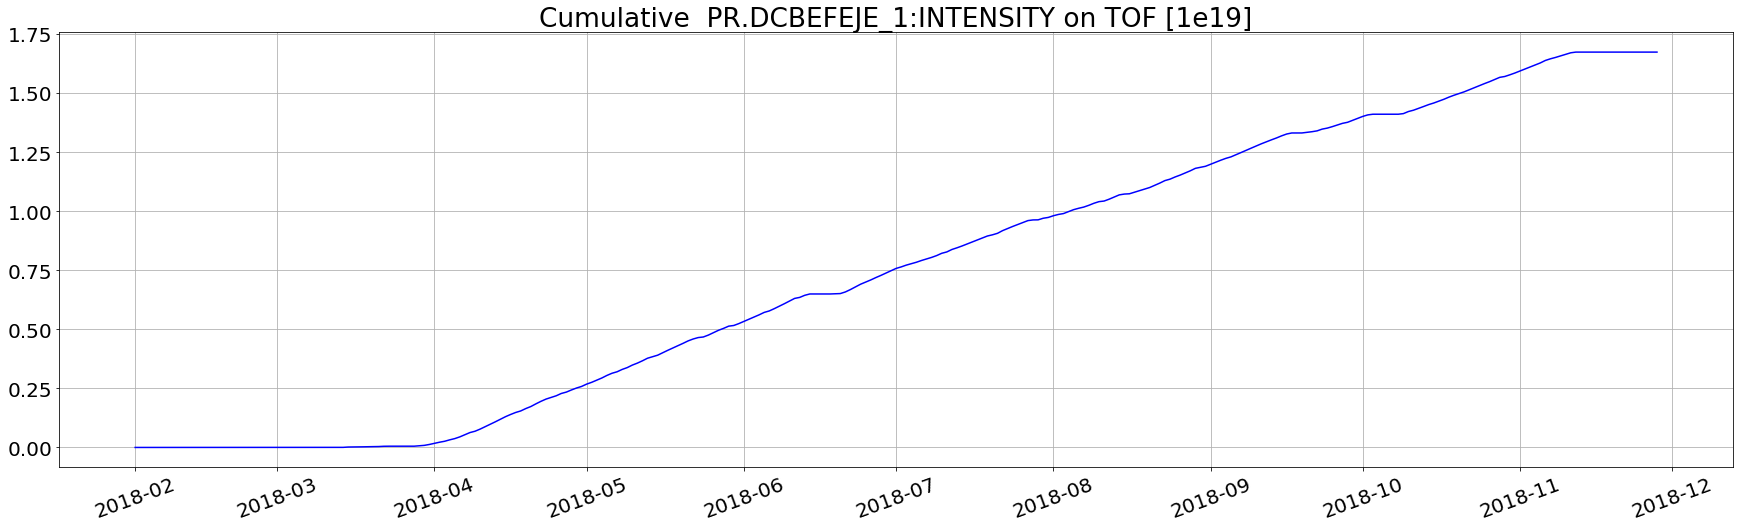

In [13]:
plt.figure(figsize=(30,8))
plt.plot(aux['value'].cumsum()/1e9,'-b')
plt.title('Cumulative  PR.DCBEFEJE_1:INTENSITY on TOF [1e19]')
plt.xticks(rotation=20);
plt.grid()

### Example 4 (cyclestamps arithmetic)

**Q: What is the efficiency of transmission between PSB and PB for TOF?**

Cyclestamps arithmetic can be used to "follow" a beam in the injector chain. 

**HINT**: "consecutive" cyclestamps from PS and PSB are 635 ms apart. 

In [19]:
t1=pd.Timestamp('2018-10-01 00:00', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:05', tz='UTC')
pd_df=nx.importNXCALS(['CPS.TGM:USER','PR.DCAFTINJ_1:INTENSITY'], t1,t2)
df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
df_ps=df.filter(nx.col('CPS@TGM:USER')=='TOF').filter(nx.col('PR@DCAFTINJ_1:INTENSITY')>500.)

pd_df=nx.importNXCALS(['PSB.TGM:USER','BR2.BCT.ACC:INTENSITY'], t1,t2)
df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
df_psb=df.withColumn('timestamp',nx.col('timestamp')+635000000) # cyclestamps arithmetic

out=nx._join_df_list([df_ps,df_psb],how='inner')
out=out.withColumn('efficiency',nx.col('PR@DCAFTINJ_1:INTENSITY')/nx.col('BR2@BCT@ACC:INTENSITY'))
print(nx._to_pandas(out, timestampConversion=False, sorted=True)[['CPS.TGM:USER','PSB.TGM:USER','efficiency']].head())

                    CPS.TGM:USER PSB.TGM:USER  efficiency
1538352006700000000          TOF          TOF    0.980367
1538352010300000000          TOF          TOF    0.977946
1538352013900000000          TOF          TOF    0.980870
1538352028300000000          TOF          TOF    0.979842
1538352035500000000          TOF          TOF    0.981096


### Example 5 (UDF scalars to scalar)

In the previous example we compute the efficiency just dividing columns. In general, for more complex, function we can use a User Defined Function. 

In [22]:
# %% UDF scalars to scalar
# This function compute the transmission efficiency between injection and extraction of the PS
def my_efficiency(current_inj,current_eje):
    if current_inj>0:
        aux=current_eje/current_inj
    else:
        aux=0.    # it is important to force the double for NXCALS
    if aux<0:
        return 0. # it is important to force the double for NXCALS
    else:
        return aux
my_udf = nx.func.udf(my_efficiency, nx.DoubleType())

t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
pd_df=nx.importNXCALS(['CPS.TGM:USER','PR.DCAFTINJ_1:INTENSITY','PR.DCBEFEJE_1:INTENSITY'], t1,t2)
spark_df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
spark_df=spark_df.withColumn('transmission efficiency',my_udf(nx.col('PR@DCAFTINJ_1:INTENSITY'),nx.col('PR@DCBEFEJE_1:INTENSITY')))

aux=nx._to_pandas(spark_df.dropna()\
    .filter(nx.col("PR@DCAFTINJ_1:INTENSITY")>2)\
    .groupby('CPS@TGM:USER').agg(nx.func.count("transmission efficiency").alias('count'),\
                                    nx.func.mean("transmission efficiency").alias('Out/In PS efficiency')))
aux=aux.sort_values('CPS.TGM:USER').set_index('CPS.TGM:USER');aux.index.name=None;print(aux.head())

         count  Out/In PS efficiency
AD      112549              0.988969
EAST1  1166882              0.990395
EAST2  1145499              0.992629
ION1     53903              0.952219
ION2     29311              0.793609


### Example 6 (UDF vector to scalar)
**Q: Histogram of the multi-Turn Extraction efficiency in 2018**

A natural extensions is to compress vector information to scalars.

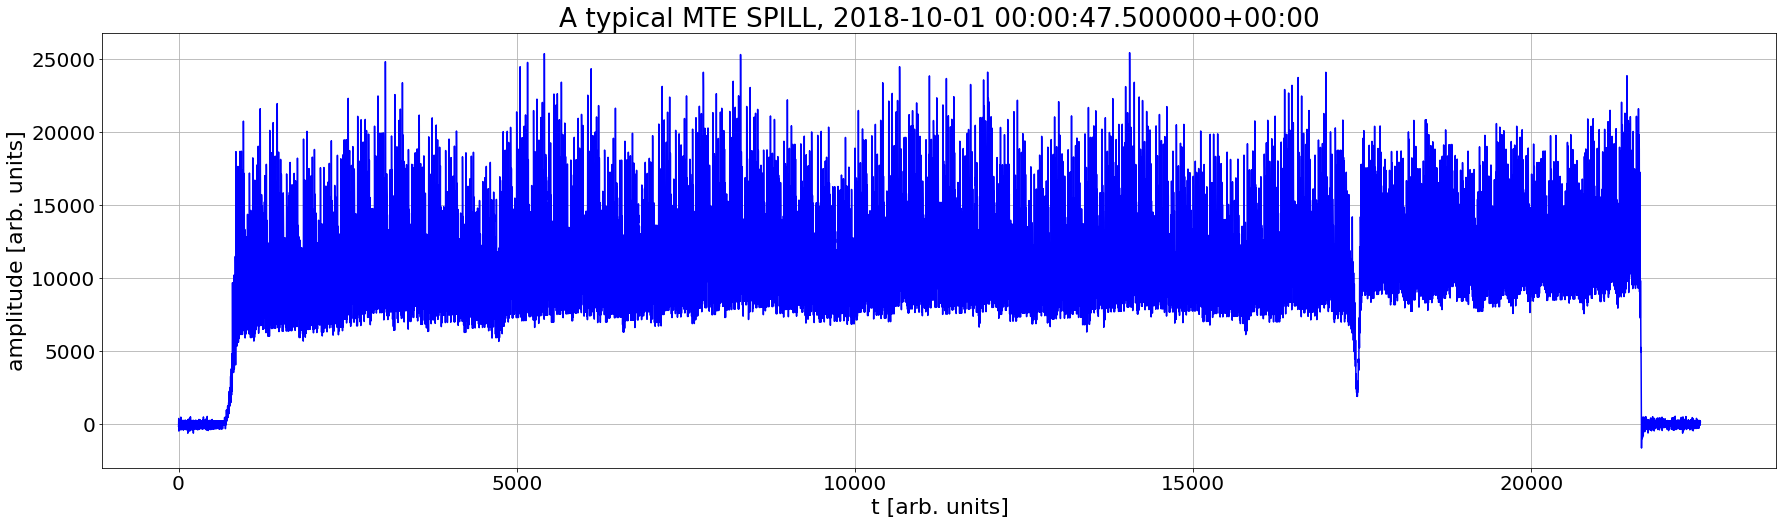

In [23]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
df=nx.importNXCALS(['CPS.TGM:USER','PR.SCOPE48.CH01:MTE_SPILL'], t1,t2)
spark_df=nx._join_df_list(df, on=['timestamp'], how='inner')
spark_df=spark_df.filter(nx.col('CPS@TGM:USER')=='SFTPRO1')
plt.figure(figsize=(30,8))
my_row=spark_df.take(2)[0]
plt.plot(my_row['PR@SCOPE48@CH01:MTE_SPILL'],'b')
plt.title(f'A typical MTE SPILL, {pd.Timestamp(my_row["timestamp"]).tz_localize("UTC")}') # it is a heavy signal (>20k samples)
plt.xlabel('t [arb. units]');plt.ylabel('amplitude [arb. units]');plt.grid(True)

In [24]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-01 00:01', tz='UTC')
df=nx.importNXCALS(['CPS.TGM:USER','CPS.LSA:CYCLE','PR.SCOPE48.CH01:MTE_SPILL','PR.SCOPE48.CH01:MTE_EFFICIENCY'], t1,t2)
df=nx._join_df_list(df, on=['timestamp'], how='inner')
df=df.filter(nx.col('CPS@TGM:USER')=='SFTPRO1')
df.limit(5).show()

+-------------------+------------+-------------+-------------------------+------------------------------+
|          timestamp|CPS@TGM:USER|CPS@LSA:CYCLE|PR@SCOPE48@CH01:MTE_SPILL|PR@SCOPE48@CH01:MTE_EFFICIENCY|
+-------------------+------------+-------------+-------------------------+------------------------------+
|1538352047500000000|     SFTPRO1|    MTE_2018_|     [-124.17984259390...|                  0.1969342292|
|1538352046300000000|     SFTPRO1|    MTE_2018_|     [160.132474568082...|                  0.1974465434|
|1538352003100000000|     SFTPRO1|    MTE_2018_|     [-348.93102797674...|                  0.1991091949|
|1538352031900000000|     SFTPRO1|    MTE_2018_|     [-127.18853975281...|                  0.1994075732|
|1538352004300000000|     SFTPRO1|    MTE_2018_|     [241.22672082312,...|                  0.1988264771|
+-------------------+------------+-------------+-------------------------+------------------------------+



In [29]:
def MTE_efficiency(myNewSpill):
    b1_idx=2066-1500
    b2_idx=6267-1500
    b3_idx=10468-1500
    b4_idx=14669-1500
    b5_idx=18871-1500
    b6_idx=23072-1500
    is1=np.mean(myNewSpill[b1_idx:b2_idx])
    is2=np.mean(myNewSpill[b2_idx:b3_idx])
    is3=np.mean(myNewSpill[b3_idx:b4_idx])
    is4=np.mean(myNewSpill[b4_idx:b5_idx])
    core=np.mean(myNewSpill[b5_idx:b6_idx])
    mySum=(is1+is2+is3+is4+core);
    MTE_efficiency=np.mean([is1,is2,is3,is4])/mySum;
    return np.float(MTE_efficiency)
my_udf = nx.func.udf(MTE_efficiency, nx.DoubleType())

new_df=df.withColumn('recomputed',my_udf(nx.col('PR@SCOPE48@CH01:MTE_SPILL')))
new_df=new_df.select(['timestamp','PR@SCOPE48@CH01:MTE_EFFICIENCY','recomputed'])
print(nx._to_pandas(new_df, timestampConversion=True, sorted=True).head())

                                  PR.SCOPE48.CH01:MTE_EFFICIENCY  recomputed
2018-10-01 00:00:03.100000+00:00                        0.199109    0.199109
2018-10-01 00:00:04.300000+00:00                        0.198826    0.198826
2018-10-01 00:00:17.500000+00:00                        0.198757    0.198757
2018-10-01 00:00:18.700000+00:00                        0.201958    0.201958
2018-10-01 00:00:31.900000+00:00                        0.199408    0.199408


In [30]:
# about 5 minutes computation
t1=pd.Timestamp('2018', tz='UTC')
t2=pd.Timestamp('2019', tz='UTC')
df=nx.importNXCALS(['CPS.TGM:USER','PR.SCOPE48.CH01:MTE_SPILL','PR.SCOPE48.CH01:MTE_EFFICIENCY'], t1,t2)
df=nx._join_df_list(df, on=['timestamp'], how='inner')
df=df.filter(nx.col('CPS@TGM:USER')=='SFTPRO1')
new_df=df.withColumn('recomputed_MTE_efficiency',my_udf(nx.col('PR@SCOPE48@CH01:MTE_SPILL')))
new_df=new_df.select(['recomputed_MTE_efficiency'])
aux=nx._to_pandas(new_df)

Text(0,0.5,'count')

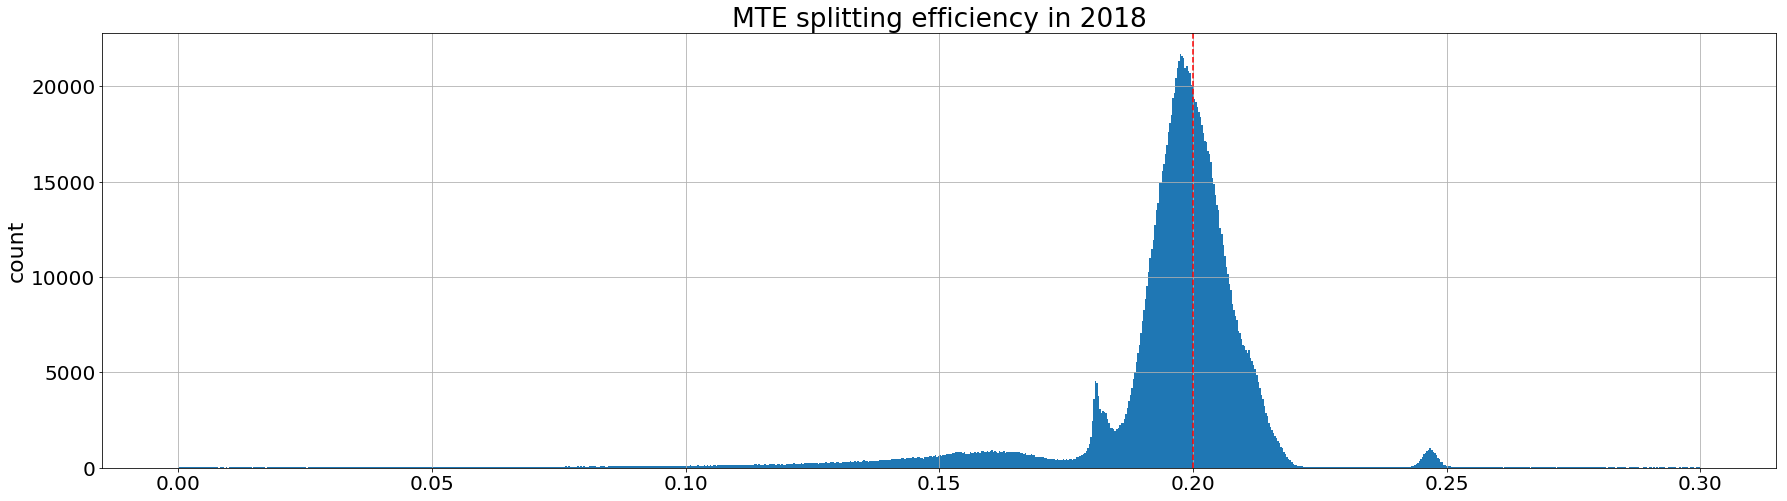

In [31]:
plt.figure(figsize=(30,8))
aux=aux[(aux['recomputed_MTE_efficiency']>0) & (aux['recomputed_MTE_efficiency']<0.3)]
plt.hist(aux['recomputed_MTE_efficiency'].values,1000);
my_ylimit=plt.ylim()
plt.plot([.2,.2],my_ylimit,'--r')
plt.ylim(my_ylimit)
plt.grid()
plt.title('MTE splitting efficiency in 2018')
plt.ylabel('count')

### Example 7 (subsampling and align scalars)

We are going to put all together in our LHC case.

In [32]:
def subSampling(variable,t1,t2,freq='300s'):
    aux=np.array(pd.date_range(t1, t2,freq=freq).astype(np.int64))
    spark_variable=nx._replace_specials(variable)
    pd_df=nx.importNXCALS([variable], t1,t2)
    def set_window(timestamp):
        try:
            return np.int(np.where(aux>timestamp)[0][0])
        except:
            return np.int(0)
    def set_window_time(window):
        try:
            return np.int((aux[window-1]+aux[window])/2)
        except:
            return np.int(0)
    udf_set_window = nx.func.udf(set_window, nx.LongType())
    udf_set_window_time = nx.func.udf(set_window_time, nx.LongType())
    spark_df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
    spark_df=spark_df.withColumn('window',udf_set_window(nx.col('timestamp')))
    spark_df=spark_df.withColumn('timeWindow',udf_set_window_time(nx.col('window')))
    return spark_df.groupby('window').agg(nx.func.mean(spark_variable).alias(spark_variable),\
        nx.func.count(spark_variable).alias('count_'+spark_variable),\
        nx.func.mean(spark_variable).alias('mean_'+spark_variable),\
        nx.func.stddev(spark_variable).alias('stddev_'+spark_variable),\
        nx.func.min(spark_variable).alias('min_'+spark_variable),\
        nx.func.max(spark_variable).alias('max_'+spark_variable),\
        nx.func.min("timeWindow").alias("timestamp")).drop('window')

In [33]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-02', tz='UTC')
my_variable_list=['ALICE:LUMI_TOT_INST','ATLAS:LUMI_TOT_INST','CMS:LUMI_TOT_INST','LHCB:LUMI_TOT_INST']\
    +['LHC.BCTFR.A6R4.B1:BEAM_INTENSITY','LHC.BCTFR.A6R4.B2:BEAM_INTENSITY']\
    +['LHC.BLM.LIFETIME:B1_BEAM_LIFETIME','LHC.BLM.LIFETIME:B2_BEAM_LIFETIME']+['RPMBB.RR17.ROD.A12B1:I_MEAS']
my_spark_variable_list=nx._replace_specials(my_variable_list)
my_list=[subSampling(i,t1,t2) for i in my_variable_list ]
spark_df=nx._join_df_list(my_list, how='outer')
aux=nx._to_pandas(spark_df.select(*my_spark_variable_list,'timestamp'), sorted=True, timestampConversion=True);print(aux[['ALICE:LUMI_TOT_INST','RPMBB.RR17.ROD.A12B1:I_MEAS']].head())

                           ALICE:LUMI_TOT_INST  RPMBB.RR17.ROD.A12B1:I_MEAS
2018-10-01 00:02:30+00:00             3.530905                      -338.99
2018-10-01 00:07:30+00:00             3.541737                      -338.99
2018-10-01 00:12:30+00:00             3.571198                      -338.99
2018-10-01 00:17:30+00:00             3.514797                      -338.99
2018-10-01 00:22:30+00:00             3.455339                      -338.99


### Example 8 (putting together, subsampling and align vectors)

To cope with bunch-by-bunch analysis we need to subsample vactors.

In [34]:
def subSamplingVector(variable, t1, t2, my_DatetimeIndex):
    aux=np.array(my_DatetimeIndex.astype(np.int64))
    spark_variable=nx._replace_specials(variable)
    pd_df=nx.importNXCALS([variable], t1,t2)
    def set_window(timestamp):
        try:
            return np.int(np.where(aux>timestamp)[0][0])
        except:
            return np.int(0)
    def set_window_time(window):
        try:
            return np.int((aux[window-1]+aux[window])/2)
            #return np.int(aux[window-1])
        except:
            return np.int(0)
    def compute_mean(x):
        try:
            aux=0
            for i in len(x):
                aux=a+x[i]
            return aux/len(x)
        except:
            return x[0]
    udf_set_window = nx.func.udf(set_window, nx.LongType())
    udf_set_window_time = nx.func.udf(set_window_time, nx.LongType())
    udf_compute_mean = nx.func.udf(compute_mean, nx.ArrayType(nx.DoubleType()))
    spark_df=nx._join_df_list(pd_df, on=['timestamp'], how='inner')
    spark_df=spark_df.withColumn('window',udf_set_window(nx.col('timestamp')))
    spark_df=spark_df.withColumn('timeWindow',udf_set_window_time(nx.col('window')))
    return spark_df.groupby('window').agg(udf_compute_mean(nx.func.collect_list(spark_variable)).alias(spark_variable),\
                                          nx.func.min("timeWindow").alias("timestamp")).drop('window')

And combining the different functions...

In [36]:
t1=pd.Timestamp('2018-10-01', tz='UTC')
t2=pd.Timestamp('2018-10-02', tz='UTC')
my_DatetimeIndex=pd.date_range(t1, t2, freq='300s')
my_variable_list=['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY','LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY','ATLAS:BUNCH_LUMI_INST','CMS:BUNCH_LUMI_INST',
                  'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H',
                  'LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V',
                  'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H',
                  'LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V']
my_spark_variable_list=nx._replace_specials(my_variable_list)
my_list1=[subSamplingVector(i,t1,t2,my_DatetimeIndex) for i in my_variable_list]

my_variable_list=['ALICE:LUMI_TOT_INST','ATLAS:LUMI_TOT_INST','CMS:LUMI_TOT_INST','LHCB:LUMI_TOT_INST']\
    +['LHC.BCTFR.A6R4.B1:BEAM_INTENSITY','LHC.BCTFR.A6R4.B2:BEAM_INTENSITY']\
    +['LHC.BLM.LIFETIME:B1_BEAM_LIFETIME','LHC.BLM.LIFETIME:B2_BEAM_LIFETIME']+['RPMBB.RR17.ROD.A12B1:I_MEAS']
my_spark_variable_list=nx._replace_specials(my_variable_list)
my_list2=[subSampling(i,t1,t2) for i in my_variable_list ]

my_list3=nx.importNXCALS(['LHC.RUNCONFIG:IP1-XING-V-MURAD',
 'LHC.RUNCONFIG:IP2-XING-V-MURAD',
 'LHC.RUNCONFIG:IP5-XING-H-MURAD',
 'LHC.RUNCONFIG:IP8-XING-H-MURAD']+['HX:BETASTAR_IP1', 'HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'], t1,t2)

spark_df=nx._join_df_list(my_list1+my_list2+list(my_list3['pyspark df'].values), how='outer')
aux=nx._to_pandas(spark_df, timestampConversion=True, sorted=True); print(aux[['LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V','LHC.RUNCONFIG:IP2-XING-V-MURAD','ATLAS:LUMI_TOT_INST']].head())

                                                  LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V  \
2018-10-01 00:02:30+00:00         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2018-10-01 00:07:30+00:00         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2018-10-01 00:12:30+00:00         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2018-10-01 00:14:20.149000+00:00                                               None   
2018-10-01 00:17:30+00:00         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                  LHC.RUNCONFIG:IP2-XING-V-MURAD  \
2018-10-01 00:02:30+00:00                                    NaN   
2018-10-01 00:07:30+00:00                                    NaN   
2018-10-01 00:12:30+00:00                                    NaN   
2018-10-01 00:14:20.149000+00:00                             NaN   
2018-10-01 00:17:30+00:00                                    NaN   

                                  ATLAS:LUMI_TOT_INST  
2018-10-01 0

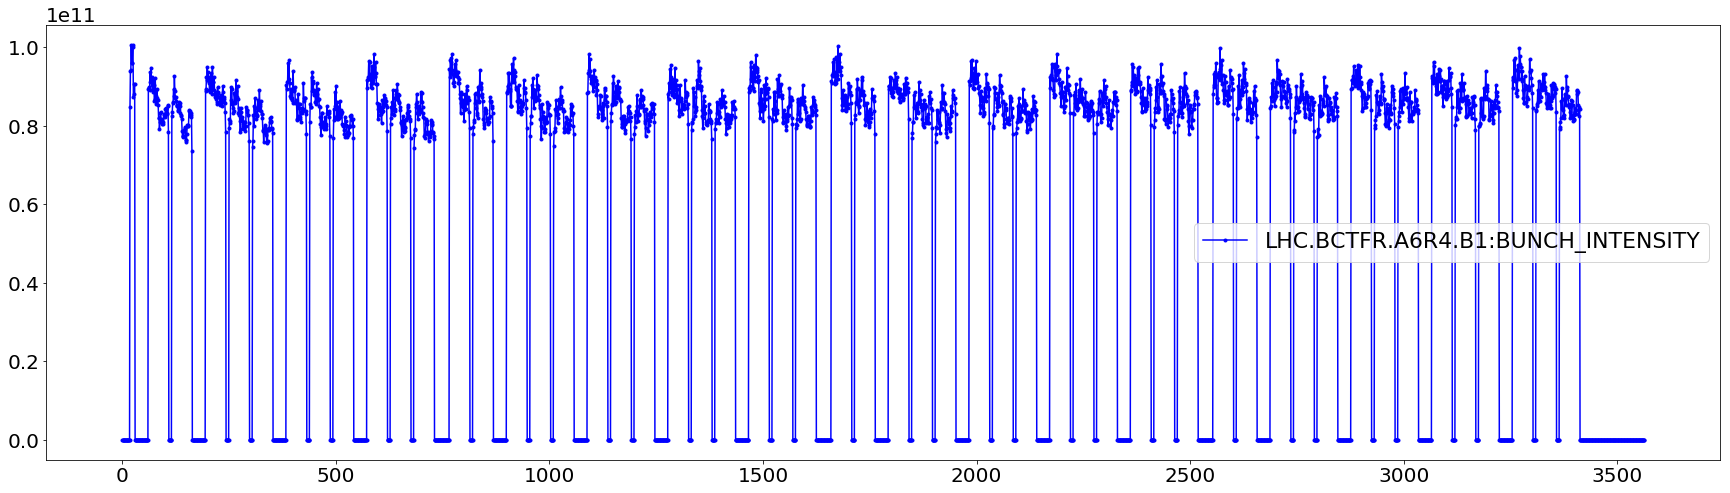

In [37]:
# Few checks
plt.figure(figsize=(30,8))
plt.plot(aux.iloc[0]['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'],'.-b', label='LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY')
plt.legend(loc='best')

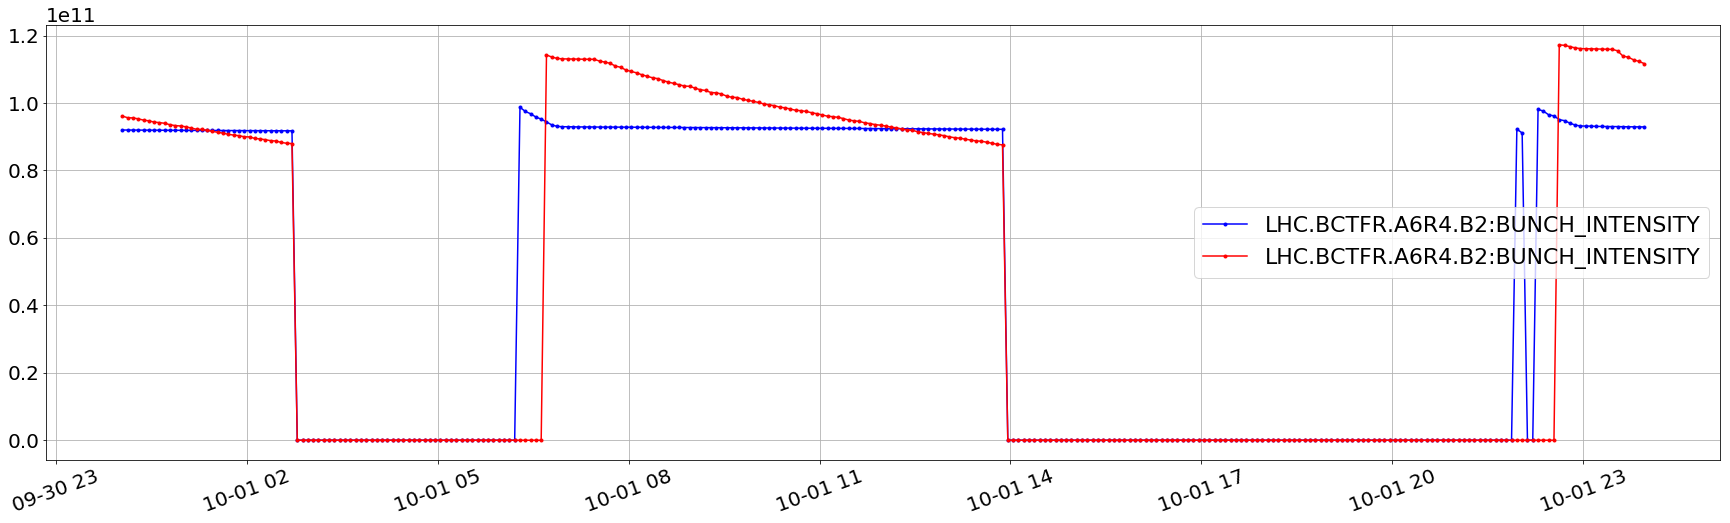

In [38]:
# Few checks
plt.figure(figsize=(30,8))
plt.plot(aux['LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'].dropna().apply(lambda x:x[6]),'.b-')
plt.plot(aux['LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'].dropna().apply(lambda x:x[2000]),'.r-')
plt.legend(loc='best')
plt.grid()
plt.xticks(rotation=20);

### Example 9 (write/read on HDFS)

Writing and reading to/from HDFS allows us to use SPARK also for the postprocessed data (maintaining the same workflow).

In [39]:
# to write
if 0:
    # very important to repartition to limit the number of files (for a single fill we will repartition to 1 file)
    spark_df.repartition(1).write.mode("overwrite").parquet("fill2.parquet")

You can check the *hdfs* path by

In [40]:
!hdfs dfs -ls /user/sterbini

Found 6 items
drwx------   - sterbini supergroup          0 2020-05-28 23:20 /user/sterbini/.Trash
drwxr-xr-x   - sterbini supergroup          0 2020-05-29 10:31 /user/sterbini/.sparkStaging
drwxr-xr-x   - sterbini supergroup          0 2020-02-07 14:38 /user/sterbini/bmode
drwxr-xr-x   - sterbini supergroup          0 2020-02-07 14:51 /user/sterbini/bmodes
drwxr-xr-x   - sterbini supergroup          0 2020-05-28 22:40 /user/sterbini/fill1.parquet
drwxr-xr-x   - sterbini supergroup          0 2020-05-28 23:37 /user/sterbini/fill2.parquet


In [48]:
spark_df=spark.read.parquet("fill*.parquet") # Very important
aux=nx._to_pandas(spark_df.select('timestamp','CMS:BUNCH_LUMI_INST'),timestampConversion=True, sorted=True)
print(aux.head())
print(aux.tail())

                                                                CMS:BUNCH_LUMI_INST
2018-10-01 00:02:30+00:00         [-0.002677366, -0.002759958, -0.004399077, -0....
2018-10-01 00:07:30+00:00         [-0.002629694, -0.002912038, -0.005541767, -0....
2018-10-01 00:12:30+00:00         [-0.003120326, -0.002868722, -0.003427472, -0....
2018-10-01 00:14:20.149000+00:00                                               None
2018-10-01 00:17:30+00:00         [-0.001818355, -0.003197438, -0.002672729, -0....
                                                                CMS:BUNCH_LUMI_INST
2018-10-02 23:42:30+00:00         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2018-10-02 23:47:30+00:00                                                      None
2018-10-02 23:52:30+00:00                                                      None
2018-10-02 23:53:54.144000+00:00                                               None
2018-10-02 23:57:30+00:00                                                   

### Conclusions

- We show some examples of **pyspark** approach we intend to use in our work-flow. We touched only the surface. 

- First impression: we think that NXCALS framework has great potential for the big data analysis. 

- **pytimber** still fundamental for the typical use (e.g., small data).

Thanks to the NXCALS team for the responsiveness and availability.

**Thank you for your attention.**